## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import numpy as np
import os
import re


In [ ]:

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

## Function Definition

In [ ]:
from sklearn.metrics import roc_auc_score

def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
    y_true (array): True binary labels.
    y_pred (array): Predicted probabilities.
    min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
    float: Scaled pAUC value.
    """
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = np.array([1.0 - x for x in y_pred])  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

## Model Definition


In [ ]:
def load_pretrained_resnet50_fine_tune_last(num_classes):
    """
    Load ResNet-50 and fine-tune only the last layer.

    Args:
    - num_classes (int): Number of output classes.

    Returns:
    - model (torch.nn.Module): Modified ResNet-50 model.
    """
    model = resnet50(pretrained=True)

    
    for name, param in model.named_parameters():
        if "layer4" not in name and "fc" not in name:
            param.requires_grad = False

    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


## Hyperparams

In [ ]:

batch_size = 32
learning_rate = 0.000005
num_epochs = 50
num_classes = 2
dropout_rate = 0.4

## Dataset Processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(root='../data/balanced_data', transform=transform)
num_classes = len(dataset.classes)


train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    [label for _, label in dataset.samples],
    test_size=0.2,
    stratify=[label for _, label in dataset.samples],
    random_state=42
)

val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


train_dataset = Subset(dataset, train_indices)
train_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
train_augmented_indices = np.random.choice(train_indices, size=len(train_indices), replace=False)
train_augmented_dataset = Subset(train_augmented_dataset, train_augmented_indices)
train_combined_dataset = ConcatDataset([train_dataset, train_augmented_dataset])

val_dataset = Subset(dataset, val_indices)
val_augmented_dataset = datasets.ImageFolder(root='../data/balanced_data', transform=augment_transform)
val_augmented_indices = np.random.choice(val_indices, size=len(val_indices), replace=False)
val_augmented_dataset = Subset(val_augmented_dataset, val_augmented_indices)
val_combined_dataset = ConcatDataset([val_dataset, val_augmented_dataset])

test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Init Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_pretrained_resnet50_fine_tune_last(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/jone/anaconda3/envs/SUTD/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jone/anaconda3/envs/SUTD/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct_train / total_train)

    
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = "saved_models/best_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved to {model_path}.")

Epoch [1/50], Train Loss: 0.6437, Train Accuracy: 0.6290, Validation Loss: 0.5850, Validation Accuracy: 0.6962
Best model saved to saved_models/best_model.pth.
Epoch [2/50], Train Loss: 0.5571, Train Accuracy: 0.7731, Validation Loss: 0.5526, Validation Accuracy: 0.7468
Best model saved to saved_models/best_model.pth.
Epoch [3/50], Train Loss: 0.4960, Train Accuracy: 0.8002, Validation Loss: 0.5090, Validation Accuracy: 0.7911
Best model saved to saved_models/best_model.pth.
Epoch [4/50], Train Loss: 0.4345, Train Accuracy: 0.8352, Validation Loss: 0.4659, Validation Accuracy: 0.7975
Best model saved to saved_models/best_model.pth.
Epoch [5/50], Train Loss: 0.3953, Train Accuracy: 0.8392, Validation Loss: 0.4602, Validation Accuracy: 0.8291
Best model saved to saved_models/best_model.pth.
Epoch [6/50], Train Loss: 0.3687, Train Accuracy: 0.8575, Validation Loss: 0.4673, Validation Accuracy: 0.7975
Epoch [7/50], Train Loss: 0.3452, Train Accuracy: 0.8710, Validation Loss: 0.4746, Valida

## Eval

In [ ]:

best_model_path = "saved_models/best_model.pth"
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"No model file found at {best_model_path}.")

print(f"Loading the best model: {best_model_path}")
model.load_state_dict(torch.load(best_model_path))
model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


pAUC = custom_metric(np.array(all_labels), np.array(all_probs), min_tpr=0.8)
print(f"Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): {pAUC:.4f}")


Loading the best model: saved_models/best_model.pth
Test Loss: 0.3674, Test Accuracy: 0.8861
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.94      0.82      0.88        39

    accuracy                           0.89        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.89      0.89      0.89        79

Partial AUC (pAUC) above TPR=0.8 (normalized to [0, 0.2]): 0.1387


## Plotting

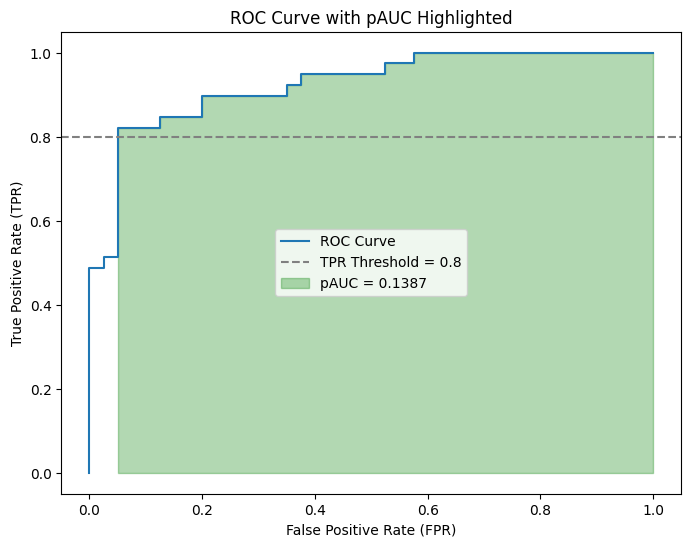

ROC Curve plot saved to saved_models/roc_curve_with_pauc.png


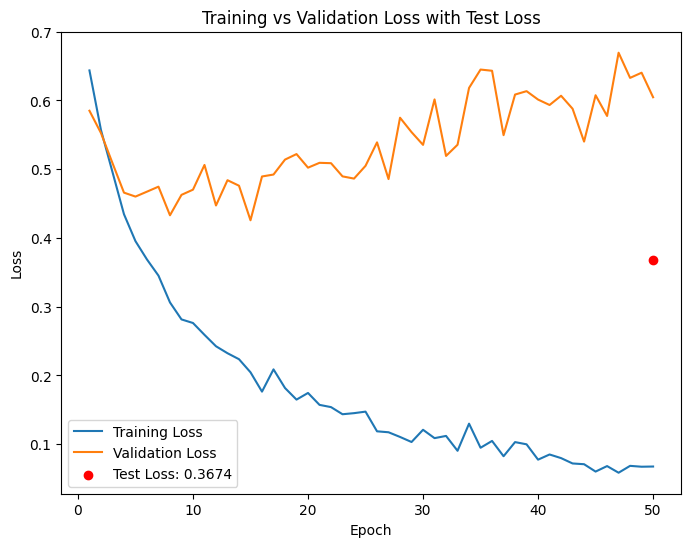

Loss plot saved to saved_models/training_vs_validation_loss.png


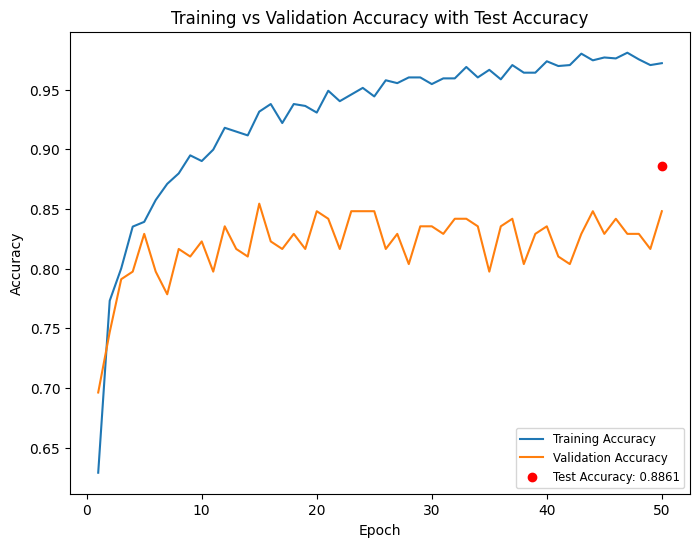

Accuracy plot saved to saved_models/training_vs_validation_accuracy.png


In [ ]:

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.axhline(y=0.8, color='gray', linestyle='--', label="TPR Threshold = 0.8")
plt.fill_between(fpr, tpr, where=(tpr >= 0.8), color='green', alpha=0.3, label=f"pAUC = {pAUC:.4f}")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with pAUC Highlighted')
plt.legend()
roc_plot_path = os.path.join("saved_models", "roc_curve_with_pauc.png")
plt.savefig(roc_plot_path)
plt.show()
print(f"ROC Curve plot saved to {roc_plot_path}")


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.scatter(len(train_losses), avg_test_loss, label=f'Test Loss: {avg_test_loss:.4f}', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss with Test Loss')
plt.legend()
loss_plot_path = os.path.join("saved_models", "training_vs_validation_loss.png")
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.scatter(len(train_accuracies), test_accuracy, label=f'Test Accuracy: {test_accuracy:.4f}', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy with Test Accuracy')
plt.legend(loc='lower right', fontsize='small')
accuracy_plot_path = os.path.join("saved_models", "training_vs_validation_accuracy.png")
plt.savefig(accuracy_plot_path)
plt.show()
print(f"Accuracy plot saved to {accuracy_plot_path}")

## Save Model Params

In [11]:
params_file_path = os.path.join("saved_models", "model_params.txt")
with open(params_file_path, "w") as f:
    f.write("Model Architecture:\n")
    f.write(str(model) + "\n\n")
    f.write("Hyperparameters:\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Number of Classes: {num_classes}\n")
    f.write(f"Dropout Rate: {dropout_rate}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")
print(f"Model parameters and architecture saved to {params_file_path}")

Model parameters and architecture saved to saved_models/model_params.txt
